In [39]:
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit

In [40]:
pdb = app.PDBFile('butane.pdb')
forcefield = app.ForceField('butane.gaff2.xml')

In [41]:
system = forcefield.createSystem(pdb.topology, nonbondedMethod=app.NoCutoff, constraints=app.HBonds)

integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

In [42]:
print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 13.384565075698099 kJ/mol
Potential energy after minimization is 5.297922227327014 kJ/mol


In [43]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 250, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(298.0*unit.kelvin)
simulation.step(5000)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
250,25.497190701468554,205.03604286426406
500,46.398537222337374,267.015436243347
750,26.84599520176167,240.4065457240899
1000,33.163205831725215,179.9038771287908
1250,61.65161056059493,272.6208921246442
1500,38.907390528700525,315.06084166175157
1750,29.548419666002047,251.84523351970756
2000,23.278937947618793,275.31331279584566
2250,30.239933265256802,259.7046803824415
2500,27.47571966245127,228.51315232697775
2750,50.69088842334548,237.95077096106013
3000,56.189629105906405,192.25254347372638
3250,42.05479478073163,184.02200487395382
3500,57.99387923206557,230.14854068700456
3750,44.94076398782266,231.15372201939766
4000,46.98419977607844,204.49954752105694
4250,26.41755584504327,260.55851193610084
4500,42.112038884372744,186.0271524145509
4750,34.95200638337849,304.5310784574159
5000,51.008604608224616,279.0739765755224


In [44]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim.dcd', 100))

# run the simulation for 1.0x10^7*2 steps - 20*2 = 40 ns
simulation.step(20000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,45.01038601064871,335.39019890970036,0
500000,999.9999999901769,30.69088260843514,282.7128360429634,1.11e+04
750000,1499.9999999783536,52.33349462863027,315.74521619896296,1.15e+04
1000000,1999.9999999665301,38.7319053549552,174.70159945422245,1.18e+04
1250000,2499.9999999547067,32.56605896519784,328.4614455823093,1.19e+04
1500000,2999.9999999428833,38.87188047280284,264.62433083209174,1.19e+04
1750000,3499.99999993106,39.814910335738375,293.4852761086803,1.19e+04
2000000,3999.9999999192364,58.45523570465185,430.3553909195181,1.19e+04
2250000,4499.9999999992715,30.781669422603006,362.65080287204233,1.19e+04
2500000,5000.000000101135,44.38006073613454,290.98939853901055,1.19e+04
2750000,5500.000000202998,52.240685633624665,245.4304244554351,1.19e+04
3000000,6000.000000304862,46.91614452021162,388.64987493074904,1.2e+04
3250000,6500.000000406725,33.3751363822

In [48]:
import mdtraj as md

traj = md.load('butane_sim.dcd', top='butane.pdb')

In [49]:
import nglview as ngl

visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(max_frame=199999)

In [50]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,LIG,0,
1,2,C2,C,1,LIG,0,
2,3,C3,C,1,LIG,0,
3,4,C4,C,1,LIG,0,
4,5,H11,H,1,LIG,0,
5,6,H12,H,1,LIG,0,
6,7,H13,H,1,LIG,0,
7,8,H21,H,1,LIG,0,
8,9,H22,H,1,LIG,0,
9,10,H31,H,1,LIG,0,


In [53]:
torsion_indices = [4, 0, 1, 7] # atoms to define the bond length
torsion = md.compute_dihedrals(traj, [torsion_indices])

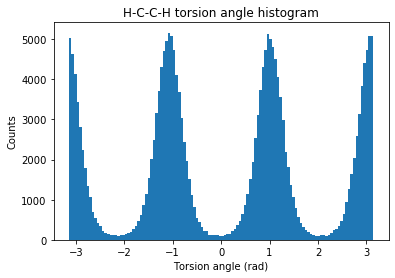

In [55]:
import matplotlib.pyplot as plt

bondcounts, binedges, otherstuff = plt.hist(torsion, bins=120)
plt.title('H-C-C-H torsion angle histogram')
plt.xlabel('Torsion angle (rad)')
plt.ylabel('Counts')
plt.show()